In [48]:
import matplotlib.pyplot as plt

In [1]:
%matplotlib notebook

C:\Python27_64\WinPython-64bit-2.7.6.4\python-2.7.6.amd64\lib\site-packages\IPython\kernel\__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated since IPython 4.0.You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
fp = 'C:\Users\NASA_\Documents\Research\ORACLES\plots\\'

In [58]:
def init_packets(name, ip='10.15.1.1',plane='N426NA'):
    """
    Function to load the inital set of packets from the data API
    """
    import numpy as np
    from datetime import datetime
    from urllib2 import urlopen
    
    toutc = lambda x: x.hour+x.minute/60.0+x.second/3600.0
    
    #Get the names of parameters to init dict
    site = 'http://{ip}/API/parameter_data/{p}/{m}/XML'.format(ip=ip,m=name,p=plane)
    r = urlopen(site)
    rr = r.read()
    rn = [s[s.rfind('<point')+len('<point')+1:s.find('/>')] for s in rr.splitlines() if s.find('point')>-1]
    try:
        dict_names = [s.split('="')[0] for s in rn[0].split('" ')]
        dict_vals = [s.split('="')[1] for s in rn[0].split('" ')]
    except IndexError:
        print 'Problem! returning string'
        return rn
        
    d = {}
    for i,n in enumerate(dict_names):
        try:
            d[n] = np.array([datetime.strptime(dict_vals[i],'%Y-%m-%d %H:%M:%S.%f')])
            if n=='timestamp':
                d['UTC'] = np.array([toutc(tt) for tt in d[n]])
        except:
            try:
                d[n] = np.array([datetime.strptime(dict_vals[i],'%Y-%m-%d %H:%M:%S')])
                if n=='timestamp':
                    d['UTC'] = np.array([toutc(tt) for tt in d[n]])
            except:
                try:
                    d[n] = np.array([float(dict_vals[i])])
                except:
                    d[n] = np.array([dict_vals[i]])
    d['ip'] = ip
    d['plane'] = plane
    return d

In [59]:
def get_packets(d,start_time=None,end_time=None,verbose=True,ip='10.15.1.1',plane='N426NA'):
    """
    Get packets from the start_time (defaults to 0) in seconds from 1970
    appends the packets to the correct values in the dict, and returns the dict
    """
    import numpy as np
    from datetime import datetime
    from urllib2 import urlopen
    
    # get the packets from web using the XML interface
    try:
        name = d['header'][0]
    except:
        print d.keys()
    try:
        ip = d['ip']
    except:
        pass
    try:
        plane = d['plane']
    except:
        pass
    last = d['timestamp'][-1]
    if len(d['header'])>1:
        epoch_time = datetime(1970,1,1)
        start_time = (last.toordinal()-epoch_time.toordinal())*24*60*60+last.hour*3600+last.minute*60+last.second
    
    site = 'http://{ip}/API/parameter_data/{p}/{m}/XML?Start={s}'.format(m=name,s=start_time,ip=ip,p=plane)
    if end_time:
        site = site+'&End={}'.format(end_time)
    r = urlopen(site)
    rr = r.read()
    rn = [s[s.rfind('<point')+len('<point')+1:s.find('/>')] for s in rr.splitlines() if s.find('point')>-1]
    nn = float(len(rn))
    if verbose: print 'number of {} points found: {}'.format(name,nn)
    if nn==0:
        return d
    toutc = lambda x: x.hour+x.minute/60.0+x.second/3600.0
    for j,rnn in enumerate(rn):
        dict_names = [s.split('="')[0] for s in rnn.split('" ')]
        dict_vals = [s.split('="')[1] for s in rnn.split('" ')]
        print u'{}%\r'.format(j/nn*100.0),
        for i,n in enumerate(dict_names):
            #print j,i,n
            try:
                du = np.array([datetime.strptime(dict_vals[i],'%Y-%m-%d %H:%M:%S.%f')])
                d[n] = np.append(d[n],du)
                if n=='timestamp':
                    d['UTC'] = np.append(d['UTC'],np.array([toutc(tt) for tt in du]))
            except:
                try:
                    du = np.array([datetime.strptime(dict_vals[i],'%Y-%m-%d %H:%M:%S')])
                    d[n] = np.append(d[n],du)
                    if n=='timestamp':
                        d['UTC'] = np.append(d['UTC'],np.array([toutc(tt) for tt in du]))
                except:
                    try:
                        d[n] = np.append(d[n],np.array([float(dict_vals[i])]))
                    except:
                        d[n] = np.append(d[n],np.array([dict_vals[i]]))
    return d

In [41]:
def startup_packet(name,ip='10.15.1.1',plane='N426NA'):
    'function to run at startup for slowly loading up the data structures, to prohibit overwhelming the data systems'
    from datetime import datetime
    
    d = init_packets(name,ip=ip,plane=plane)
    
    # Try and loop a few times to get the right start time and load slowly
    t = datetime.now()
    epoch_time = datetime(1970,1,1)
    start_time = (t.toordinal()-epoch_time.toordinal())*24*60*60
    now_time = (t.toordinal()-epoch_time.toordinal())*24*60*60+t.hour*3600+t.minute*60+t.second
    for i in xrange(48):
        end_time = start_time+3600/2
        d = get_packets(d,start_time=start_time,end_time=end_time,ip=ip,plane=plane)
        if start_time>now_time:
            break
        else:
            start_time = end_time
    d['stop_update'] = False
    return d

In [145]:
def update_packets(d):
    'Function to be used in the threading module to update the data dict with incoming packets'
    import time
    from datetime import datetime
    i=0
    ee = 0
    d['stop_update'] = False
    while True:
        if d.get('stop_update',False):
            break
        time.sleep(1)
        t = datetime.now()
        epoch_time = datetime(1970,1,1)
        today_time = (t.toordinal()-epoch_time.toordinal())*24*60*60
        now_time = today_time+t.hour*3600+t.minute*60+t.second
        start_time = today_time+d['timestamp'][-1].hour*3600+d['timestamp'][-1].minute*60+d['timestamp'][-1].second
        try:
            d = get_packets(d,start_time=start_time)
        except:
            if ee>600:
                print 'Time out, no more packets'
                break
            else:
                ee = ee+1
        i=i+1
        #print i
        #if i>11:
        #    d['stop_update']=True
    return d

In [82]:
import threading
help(threading.Thread)

Help on class Thread in module threading:

class Thread(_Verbose)
 |  A class that represents a thread of control.
 |  
 |  This class can be safely subclassed in a limited fashion.
 |  
 |  Method resolution order:
 |      Thread
 |      _Verbose
 |      __builtin__.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, group=None, target=None, name=None, args=(), kwargs=None, verbose=None)
 |      This constructor should always be called with keyword arguments. Arguments are:
 |      
 |      *group* should be None; reserved for future extension when a ThreadGroup
 |      class is implemented.
 |      
 |      *target* is the callable object to be invoked by the run()
 |      method. Defaults to None, meaning nothing is called.
 |      
 |      *name* is the thread name. By default, a unique name is constructed of
 |      the form "Thread-N" where N is a small decimal number.
 |      
 |      *args* is the argument tuple for the target invocation. Defaults to ().
 |      
 |  

In [146]:
th = threading.Thread(target=update_packets,args=([s]))

In [ ]:
th.run()

In [ ]:
s['stop_update']

In [ ]:
s['UTC'][-1]

In [20]:
iwg = startup_packet('IWG1',ip='10.16.1.1',plane='N439NA')

number of IWG1 points found: 0.0
number of IWG1 points found: 0.0
number of IWG1 points found: 0.0
number of IWG1 points found: 0.0
number of IWG1 points found: 0.0
number of IWG1 points found: 0.0
number of IWG1 points found: 0.0
number of IWG1 points found: 0.0
number of IWG1 points found: 0.0
number of IWG1 points found: 0.0
number of IWG1 points found: 0.0
number of IWG1 points found: 0.0
number of IWG1 points found: 0.0
number of IWG1 points found: 0.0
number of IWG1 points found: 0.0
number of IWG1 points found: 0.0
number of IWG1 points found: 0.0
number of IWG1 points found: 0.0
number of IWG1 points found: 0.0
number of IWG1 points found: 590.0
number of IWG1 points found: 1801.0
number of IWG1 points found: 1801.0
number of IWG1 points found: 1801.0
number of IWG1 points found: 1801.0
number of IWG1 points found: 1801.0
number of IWG1 points found: 1801.0


In [44]:
s = startup_packet('4STARB',ip='10.16.1.1',plane='N439NA')

number of 4STARB points found: 0.0
0.0
number of 4STARB points found: 0.0
0.0
number of 4STARB points found: 0.0
0.0
number of 4STARB points found: 0.0
0.0
number of 4STARB points found: 0.0
0.0
number of 4STARB points found: 0.0
0.0
number of 4STARB points found: 0.0
0.0
number of 4STARB points found: 0.0
0.0
number of 4STARB points found: 0.0
0.0
number of 4STARB points found: 0.0
0.0
number of 4STARB points found: 0.0
0.0
number of 4STARB points found: 0.0
0.0
number of 4STARB points found: 0.0
0.0
number of 4STARB points found: 0.0
0.0
number of 4STARB points found: 0.0
0.0
number of 4STARB points found: 0.0
0.0
number of 4STARB points found: 0.0
0.0
number of 4STARB points found: 0.0
0.0
number of 4STARB points found: 0.0
0.0
number of 4STARB points found: 589.0
589.0
number of 4STARB points found: 1801.0
1801.0
number of 4STARB points found: 1801.0
1801.0
number of 4STARB points found: 1801.0
1801.0
number of 4STARB points found: 1801.0
1801.0
number of 4STARB points found: 1801.

In [50]:
s = get_packets(s,ip='10.16.1.1',plane='N439NA')

number of 4STARB points found: 6322.0


In [80]:
d = get_packets(d)

number of 4STAR points found: 8056.0


In [82]:
higear = startup_packet('HIGEAR')

number of HIGEAR points found: 0.0
number of HIGEAR points found: 0.0
number of HIGEAR points found: 0.0
number of HIGEAR points found: 0.0
number of HIGEAR points found: 0.0
number of HIGEAR points found: 0.0
number of HIGEAR points found: 0.0
number of HIGEAR points found: 0.0
number of HIGEAR points found: 0.0
number of HIGEAR points found: 0.0
number of HIGEAR points found: 0.0
number of HIGEAR points found: 0.0
number of HIGEAR points found: 0.0
number of HIGEAR points found: 0.0
number of HIGEAR points found: 791.0
number of HIGEAR points found: 1801.0
number of HIGEAR points found: 1801.0
number of HIGEAR points found: 1801.0
number of HIGEAR points found: 1801.0
number of HIGEAR points found: 1801.0
number of HIGEAR points found: 1801.0
number of HIGEAR points found: 1801.0
number of HIGEAR points found: 1801.0
number of HIGEAR points found: 1801.0
number of HIGEAR points found: 1801.0
number of HIGEAR points found: 1801.0
number of HIGEAR points found: 1801.0
number of HIGEAR 

In [85]:
higear.keys()

['UTC', 'cn', 'scatg', 'scatb', 'header', 'uis', 'timestamp', 'cnhot', 'scatr']

In [17]:
iwg.keys()

['UTC',
 'header',
 'solar_zenith',
 'pitch',
 'sun_elev_ac',
 'radar_alt',
 'mach_number',
 'side_slip',
 'vert_velocity',
 'ambient_temp',
 'total_temp',
 'true_airspeed',
 'sun_az_grd',
 'indicated_airspeed',
 'grnd_spd',
 'latitude',
 'wgs_84_alt',
 'sun_az_ac',
 'angle_of_attack',
 'true_hdg',
 'track',
 'timestamp',
 'static_press',
 'drift',
 'dynamic_press',
 'vert_wind_spd',
 'wind_dir',
 'wind_speed',
 'dew_point',
 'press_alt',
 'cabin_pressure',
 'longitude',
 'roll',
 'gps_msl_alt']

In [46]:
s.keys()

['el',
 'vis',
 'nm865',
 'nir',
 'nm1559',
 'UTC',
 'quad',
 'timestamp',
 'nm675',
 'nm1236',
 'lon',
 'nm781',
 'header',
 'angstrom',
 'nm452',
 'nm501',
 'lat',
 'nm1020',
 'az',
 'mode']

In [55]:
import threading

In [57]:
help(threading)

Help on module threading:

NAME
    threading - Thread module emulating a subset of Java's threading model.

FILE
    c:\python27_64\winpython-64bit-2.7.6.4\python-2.7.6.amd64\lib\threading.py

CLASSES
    __builtin__.object
        thread._local
    _Verbose(__builtin__.object)
        Thread
    
    class Thread(_Verbose)
     |  A class that represents a thread of control.
     |  
     |  This class can be safely subclassed in a limited fashion.
     |  
     |  Method resolution order:
     |      Thread
     |      _Verbose
     |      __builtin__.object
     |  
     |  Methods defined here:
     |  
     |  __init__(self, group=None, target=None, name=None, args=(), kwargs=None, verbose=None)
     |      This constructor should always be called with keyword arguments. Arguments are:
     |      
     |      *group* should be None; reserved for future extension when a ThreadGroup
     |      class is implemented.
     |      
     |      *target* is the callable object to be in

<IPython.core.display.Javascript object>


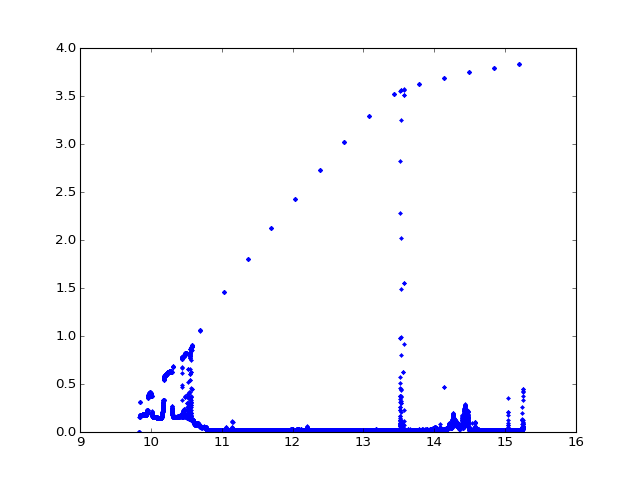

In [51]:
plt.figure()
po = plt.plot(s['UTC'],s['nm501'],'.')

In [83]:
iwg = startup_packet('IWG1')

number of IWG1 points found: 0.0
number of IWG1 points found: 0.0
number of IWG1 points found: 0.0
number of IWG1 points found: 0.0
number of IWG1 points found: 0.0
number of IWG1 points found: 0.0
number of IWG1 points found: 0.0
number of IWG1 points found: 0.0
number of IWG1 points found: 0.0
number of IWG1 points found: 0.0
number of IWG1 points found: 0.0
number of IWG1 points found: 0.0
number of IWG1 points found: 0.0
number of IWG1 points found: 0.0
number of IWG1 points found: 789.0
number of IWG1 points found: 1801.0
number of IWG1 points found: 1801.0
number of IWG1 points found: 1801.0
number of IWG1 points found: 1801.0
number of IWG1 points found: 1801.0
number of IWG1 points found: 1801.0
number of IWG1 points found: 1801.0
number of IWG1 points found: 1801.0
number of IWG1 points found: 1801.0
number of IWG1 points found: 1801.0
number of IWG1 points found: 1801.0
number of IWG1 points found: 1801.0
number of IWG1 points found: 1801.0
number of IWG1 points found: 1801.0

In [64]:
w = startup_packet('WISPER')

number of WISPER points found: 0.0
number of WISPER points found: 0.0
number of WISPER points found: 0.0
number of WISPER points found: 0.0
number of WISPER points found: 0.0
number of WISPER points found: 0.0
number of WISPER points found: 0.0
number of WISPER points found: 0.0
number of WISPER points found: 0.0
number of WISPER points found: 0.0
number of WISPER points found: 0.0
number of WISPER points found: 0.0
number of WISPER points found: 0.0
number of WISPER points found: 0.0
number of WISPER points found: 791.0
number of WISPER points found: 1801.0
number of WISPER points found: 1801.0
number of WISPER points found: 1801.0
number of WISPER points found: 1801.0
number of WISPER points found: 1801.0
number of WISPER points found: 1801.0
number of WISPER points found: 1801.0
number of WISPER points found: 1801.0
number of WISPER points found: 1801.0
number of WISPER points found: 1801.0
number of WISPER points found: 1801.0
number of WISPER points found: 1801.0
number of WISPER 

In [65]:
w.keys()

['pic0_delo',
 'v7',
 'state_valve',
 'v12',
 'cvi_lwc',
 'v10',
 'v11',
 'pic1_tbox',
 'v14',
 'v15',
 'header',
 'p_user_hpa',
 'temp_back_c',
 'vref_24',
 'cvi_enhancement',
 'pic1_deld_cal',
 'cvi_dcut50',
 'timestamp',
 'pic0_deld',
 'pic1_qh2o_cal',
 'f_user_slpm',
 'days_since_year',
 'pic1_delo_cal',
 'pic1_deld',
 'v9',
 'pic1_pcav',
 'v13',
 'pic0_delo_cal',
 'air_pres',
 'UTC',
 'p_samp_hpa',
 'f_byp_slpm',
 'cvi_vflow',
 'heat_4_c',
 'p_onb_hpa',
 'v4',
 'state_user',
 'iwg1_timestamp',
 'pic0_pcav',
 'v1',
 'v2',
 'v3',
 'v0',
 'pic0_tbox',
 'v6',
 'pic0_qh2o_cal',
 'v8',
 'p_byp_hpa',
 'air_speed',
 'pic1_tcav',
 'air_temp',
 'temp_ext_c',
 'state_flow',
 'pic1_qh2o',
 'nsample',
 'temp_fan_c',
 'pic0_tcav',
 'heat_1_c',
 'state_mode',
 'cvi_dilution',
 'heat_3_c',
 'p_bot_psi',
 'pic1_delo',
 'f_dry_slpm',
 'heat_2_c',
 'pic0_qh2o',
 'pic0_deld_cal',
 'v5']

In [67]:
w = get_packets(w)

number of WISPER points found: 346.0


<IPython.core.display.Javascript object>


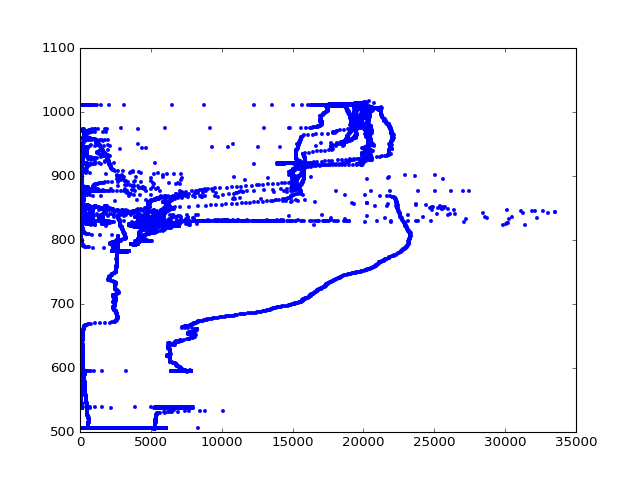

In [70]:
plt.figure()
plt.plot(w['pic0_qh2o_cal'],w['air_pres'],'.')

<IPython.core.display.Javascript object>


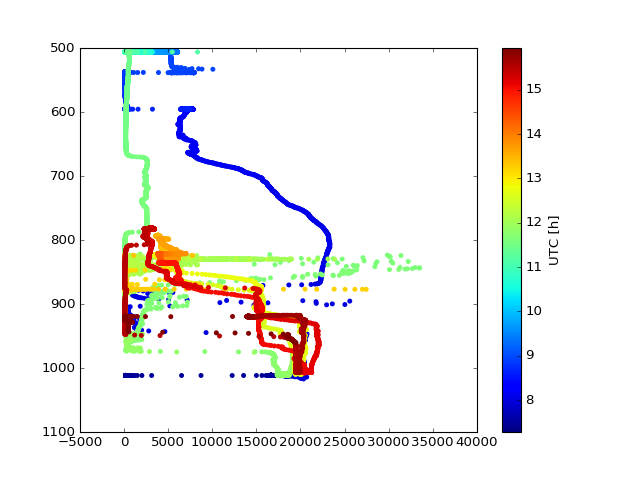

In [75]:
plt.figure()
cb = plt.scatter(w['pic0_qh2o_cal'],w['air_pres'],c=w['UTC'],edgecolor='None')
plt.ylim(1100,500)
b = plt.colorbar(cb)
b.set_label('UTC [h]')

In [76]:
w = get_packets(w)

number of WISPER points found: 506.0


<IPython.core.display.Javascript object>


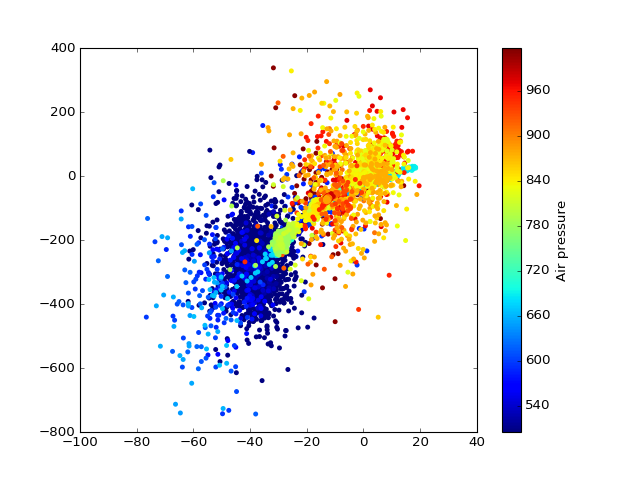

In [79]:
plt.figure()
ps = plt.scatter(w['pic0_delo_cal'][w['pic0_qh2o_cal']>200.0],w['pic0_deld_cal'][w['pic0_qh2o_cal']>200.0],
                 c=w['air_pres'][w['pic0_qh2o_cal']>200.0],edgecolor='None')
b = plt.colorbar(ps)
b.set_label('Air pressure')

<IPython.core.display.Javascript object>


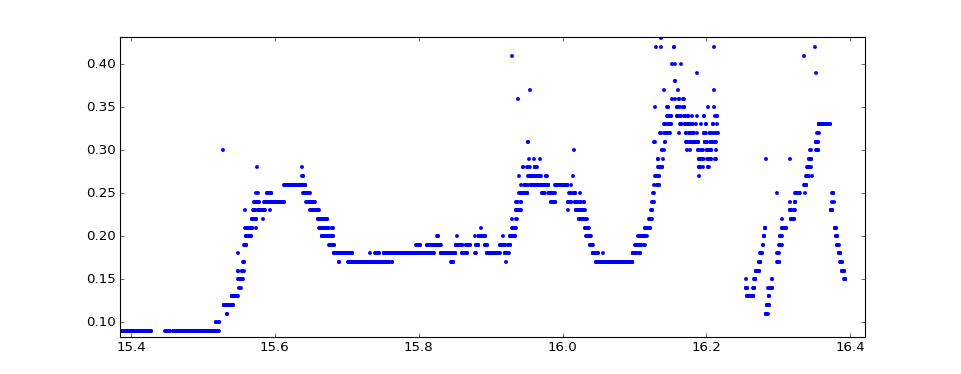

In [81]:
plt.figure()
plt.plot(d['UTC'],d['aod_500_nm'],'.')

<IPython.core.display.Javascript object>


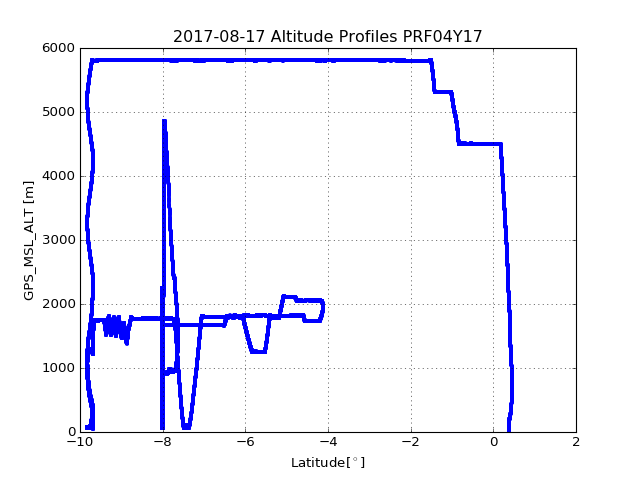

In [84]:
plt.figure()
plt.plot(iwg['latitude'],iwg['gps_msl_alt'],'.')
plt.xlabel('Latitude[$^\\circ$]')
plt.ylabel('GPS_MSL_ALT [m]')
plt.grid()
plt.title('2017-08-17 Altitude Profiles PRF04Y17')
plt.savefig(fp+'PRF04_alt_lat.png',dpi=600,transparent=True)

In [ ]:
instruments = ['IWG1','4STAR','HIGEAR','COMA','UND','OZONE','SSFR','HSRL','WISPER','SP2']

In [ ]:
data = {}
for na in instruments:
    try:
        data[na] = init_packets(na)
        data[na] = get_packets(na,start_time=)